In [32]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import glob
import sys
import corner
import numpy as np
from astropy.table import Table
import math, scipy
from scipy.interpolate import interp1d
import pyccl as ccl
sys.path.append('../../pinocchio/')   
import pinocchio_mass_richness_relation as sim_mr_rel
import pinocchio_binning_scheme as binning_scheme
sys.path.append('../../modules/')
import class_richness_mass_relation as rm_relation
import cosmology
sys.path.append('../../modules/likelihood/')
import model_cluster_abundance as cl_count
import model_cluster_abundance
import model_stacked_cluster_mass
import forecast

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Define Count and lensing mass models

In [33]:
Omega_c_true = 0.30711 - 0.048254
Omega_b_true = 0.048254
sigma8_true = .8288
Omegam_true = 0.30711
cosmo = ccl.Cosmology(Omega_c = Omega_c_true, Omega_b = Omega_b_true, h = 0.6777, sigma8 = sigma8_true, n_s=0.96)

In [34]:
logMass_bin = binning_scheme.LogMass_bin
Z_bin = binning_scheme.Z_bin
Richness_bin = binning_scheme.Richness_bin

In [35]:
log10m0, z0 = sim_mr_rel.log10m0, sim_mr_rel.z0
proxy_mu0, proxy_muz, proxy_mulog10m =  sim_mr_rel.proxy_mu0, sim_mr_rel.proxy_muz, sim_mr_rel.proxy_mulog10m
proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m =  sim_mr_rel.proxy_sigma0, sim_mr_rel.proxy_sigmaz, sim_mr_rel.proxy_sigmalog10m
theta_rm = [log10m0, z0, proxy_mu0, proxy_muz, proxy_mulog10m, proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m]
which_model = sim_mr_rel.which_model
sigma_wl_obs_log10mass = sim_mr_rel.sigma_wl_obs_log10mass
sigma_wl_log10mass = sim_mr_rel.sigma_wl_log10mass
sigma_wl_tot_log10mass = (sigma_wl_log10mass**2 + sigma_wl_obs_log10mass**2)**(1/2)

In [36]:
Omega_c_true = 0.30711 - 0.048254
Omega_b_true = 0.048254
sigma8_true = .8288
Omegam_true = 0.30711
True_value = [Omega_c_true + Omega_b_true, sigma8_true]

cosmo = ccl.Cosmology(Omega_c = Omegam_true - 0.048254, Omega_b = 0.048254, 
                              h = 0.6777, sigma8 = sigma8_true, n_s=0.96)
#halo model
massdef = ccl.halos.massdef.MassDef('vir', 'critical',)
hmd = ccl.halos.hmfunc.MassFuncDespali16( mass_def=massdef)
halobias_fct = ccl.halos.hbias.tinker10.HaloBiasTinker10(mass_def=massdef, mass_def_strict=True)
CosmologyObject = cosmology.Cosmology(hmf=hmd, bias_model=halobias_fct)

In [37]:
which_model

'log_normal_poisson_scatter'

In [42]:
RM1 = rm_relation.Richness_mass_relation()
RM1.select(which = 'log_normal_poisson_scatter')
RM2 = rm_relation.Richness_mass_relation()
RM2.select(which = 'log_normal_poisson_log_scatter')

In [54]:
where_cat = '/sps/lsst/users/cpayerne/1000xsimulations/1000_simulations/afumagalli/catalogs/plc_14/*'
file=glob.glob(where_cat)
def pinocchio_sim(index_simu=1):
    #generate mass, richness, redshift catalog
    file_sim=file[index_simu]
    dat = pd.read_csv(file_sim ,sep=' ',skiprows=12, names=['M','z','dec','ra'])
    ra, dec, redshift, Mvir_true = dat['ra'], dat['dec'], dat['z'], dat['M']/0.6777
    mask = np.log10(Mvir_true) > 14.2
    ra, dec, redshift, Mvir_true = ra[mask], dec[mask], redshift[mask], Mvir_true[mask]
    log10Mvir_obs = np.log10(Mvir_true) + sigma_wl_tot_log10mass * np.random.randn(len(np.log10(Mvir_true)))
    Mvir = 10**log10Mvir_obs
    richness1 = np.exp(RM1.lnLambda_random(np.log10(Mvir_true), redshift, theta_rm))
    richness2 = np.exp(RM2.lnLambda_random(np.log10(Mvir_true), redshift, theta_rm))
    return redshift, Mvir_true, Mvir, richness1, richness2
redshift, Mvir_true, Mvir, richness1, richness2 = pinocchio_sim(index_simu=1)

In [55]:
richness_grid = np.logspace(np.log10(10), np.log10(200), 310)
logm_grid = np.linspace(14.2, 16, 200)
z_grid = np.linspace(.2, 1, 201)

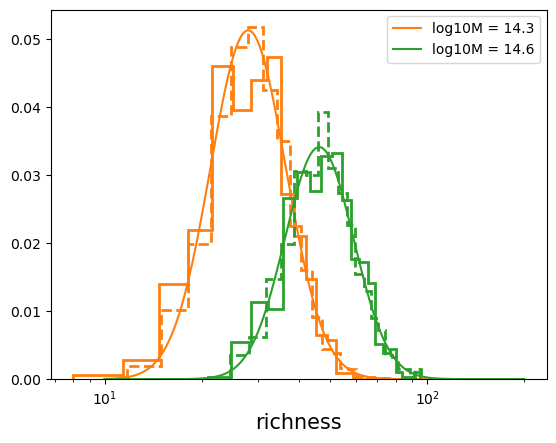

In [60]:
mass_center = 14.3
mask= (np.log10(Mvir_true) > mass_center-0.05)*(np.log10(Mvir_true) < mass_center+0.05)
z_center = 0.3
mask*= (redshift > z_center-0.05)*(redshift < z_center+0.05)
plt.plot(richness_grid, RM.pdf_richness_mass_relation(richness_grid, mass_center, z_center, theta_rm,), '-C1', label = 'log10M = ' + str(mass_center))
plt.hist(richness1[mask], density=True, bins=20, histtype='step', align='mid', lw=2, color= 'C1')
plt.hist(richness2[mask], density=True, bins=20, histtype='step', align='mid', ls = '--', lw=2, color= 'C1')
#
mass_center = 14.6
mask= (np.log10(Mvir_true) > mass_center-0.05)*(np.log10(Mvir_true) < mass_center+0.05)
z_center = 0.3
mask*= (redshift > z_center-0.05)*(redshift < z_center+0.05)
plt.plot(richness_grid, RM.pdf_richness_mass_relation(richness_grid, mass_center, z_center, theta_rm,), '-C2', label = 'log10M = ' + str(mass_center))
plt.hist(richness1[mask], density=True, bins=20, histtype='step', align='mid', lw=2, color= 'C2')
plt.hist(richness2[mask], density=True, bins=20, histtype='step', align='mid', lw=2, ls = '--', color= 'C2')

plt.xscale('log')
plt.xlabel('richness', fontsize=15)
plt.legend()

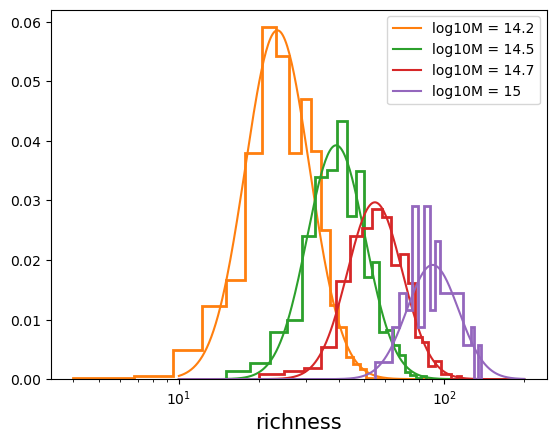

In [51]:
mass_center = 14.2
mask= (np.log10(Mvir_true) > mass_center-0.05)*(np.log10(Mvir_true) < mass_center+0.05)
z_center = 0.3
mask*= (redshift > z_center-0.05)*(redshift < z_center+0.05)
plt.plot(richness_grid, RM.pdf_richness_mass_relation(richness_grid, mass_center, z_center, theta_rm,), '-C1', label = 'log10M = ' + str(mass_center))
plt.hist(richness1[mask], density=True, bins=20, histtype='step', lw=2, color= 'C1')
#
mass_center = 14.5
mask= (np.log10(Mvir_true) > mass_center-0.05)*(np.log10(Mvir_true) < mass_center+0.05)
z_center = 0.3
mask*= (redshift > z_center-0.05)*(redshift < z_center+0.05)
plt.plot(richness_grid, RM.pdf_richness_mass_relation(richness_grid, mass_center, z_center, theta_rm,), '-C2', label = 'log10M = ' + str(mass_center))
plt.hist(richness1[mask], density=True, bins=20, histtype='step', lw=2, color= 'C2')
#
mass_center = 14.7
mask= (np.log10(Mvir_true) > mass_center-0.05)*(np.log10(Mvir_true) < mass_center+0.05)
z_center = 0.3
mask*= (redshift > z_center-0.05)*(redshift < z_center+0.05)
plt.plot(richness_grid, RM.pdf_richness_mass_relation(richness_grid, mass_center, z_center, theta_rm,), '-C3', label = 'log10M = ' + str(mass_center))
plt.hist(richness1[mask], density=True, bins=20, histtype='step', lw=2, color= 'C3')
#
mass_center = 15
mask= (np.log10(Mvir_true) > mass_center-0.05)*(np.log10(Mvir_true) < mass_center+0.05)
z_center = 0.3
mask*= (redshift > z_center-0.05)*(redshift < z_center+0.05)
plt.plot(richness_grid, RM.pdf_richness_mass_relation(richness_grid, mass_center, z_center, theta_rm,), '-C4', label = 'log10M = ' + str(mass_center))
plt.hist(richness1[mask], density=True, bins=20, histtype='step', lw=2, color= 'C4')
plt.xscale('log')
plt.xlabel('richness', fontsize=15)
plt.legend()